Bootstrap analysis

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import aplpy
import pandas as pd
from astropy.io import fits
from astropy.table import Table
from astropy.coordinates import SkyCoord
from scipy.optimize import curve_fit
from astropy.stats import bootstrap
plt.rcParams.update({'font.size': 18})
%matplotlib widget


In [2]:
def generate_RA_DEC_mesh(hdr):
    """generate_RA_DEC_mesh

    Generates the RA and DEC grid for the intensity map

    """
    if 'CDELT1' in hdr.header:
        RA_delt = hdr.header['CDELT1']
        DEC_delt = hdr.header['CDELT2']

    if 'CD1_1' in hdr.header:
        RA_delt = hdr.header['CD1_1']
        DEC_delt = hdr.header['CD2_2']

    RA_ref = (hdr.header['CRPIX1'])
    DEC_ref = (hdr.header['CRPIX2'])
    RA_ref_value = hdr.header['CRVAL1']
    DEC_ref_value = hdr.header['CRVAL2']
    RA_axis_len = hdr.header['NAXIS1']
    DEC_axis_len = hdr.header['NAXIS2']

    RA_axis = np.arange(1,RA_axis_len+1)
    DEC_axis = np.arange(1,DEC_axis_len+1)
    DEC_axis_modified = np.arange(1,RA_axis_len+1)
    
    DEC_array = (DEC_axis - DEC_axis_len/2)*DEC_delt + DEC_ref_value
    DEC_array_modified = (DEC_axis_modified - RA_axis_len/2)*DEC_delt + DEC_ref_value
    RA_array = RA_ref_value-(RA_axis - RA_axis_len/2)*(RA_delt*(-1)/np.cos(DEC_array_modified*0.01745))

    # #making a meshgrid from the arrays
    DEC_grid,RA_grid = np.meshgrid(DEC_array,RA_array , sparse=False, indexing='ij')
    return DEC_grid,RA_grid

def Calc_l(ra1,dec1,ra2,dec2):

    c1 = SkyCoord(ra1,dec1,unit = 'deg')
    c2 = SkyCoord(ra2,dec2,unit = 'deg')
    sep = c1.separation(c2)
    return sep.arcminute
    
def wrapper(Angle_grid):
    while ((np.nanmax(Angle_grid)>90) or (np.nanmin(Angle_grid)<-90)):
        Angle_selector =Angle_grid>90
        Angle_grid[Angle_selector] = Angle_grid[Angle_selector] - 180
        Angle_selector = Angle_grid<-90
        Angle_grid[Angle_selector] = Angle_grid[Angle_selector] + 180
    return Angle_grid

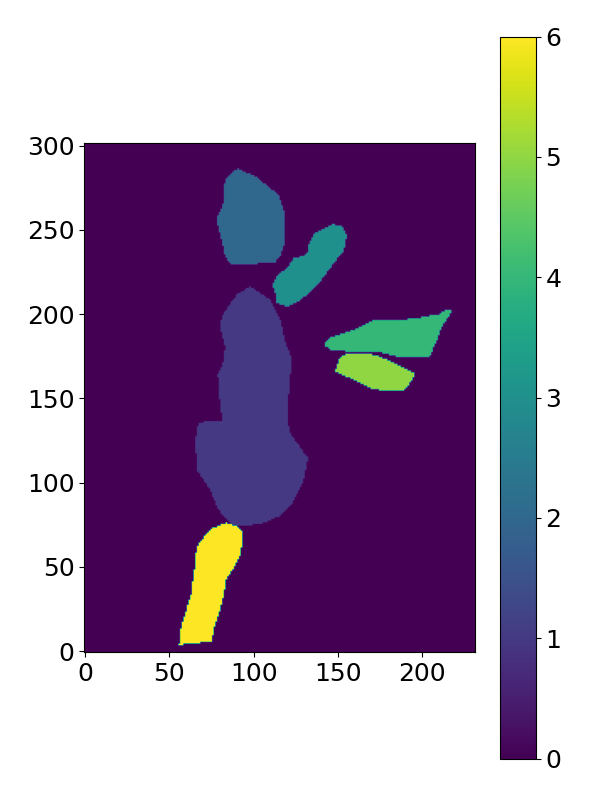

In [3]:
########## importing and testing the file
FITS1 = '../FITS_file/new_fits/DR21_OTF_full_pipeline.fits'
FITS2 = '../FITS_file/new_fits/DR21_full_NH2_Repr.fits'
FITS3 = '../FITS_file/new_fits/DR21_full_Tdust_Repr.fits'
FITS4 = '../FITS_file/new_fits/DR21_full_IRAC4_Repr.fits'
FITS5 = '../FITS_file/new_fits/DR21_full_Her250_Repr.fits'
FITS6 = '../FITS_file/new_fits/DR21_full_Fil_Mask.fits'

hdul = fits.open(FITS1)
hdul2 = fits.open(FITS2)
hdul3 = fits.open(FITS3)
hdul4 = fits.open(FITS4)
hdul5 = fits.open(FITS5)
hdul6 = fits.open(FITS6)

# print(hdul.info())

MapStokesI = hdul[0]
MapStokesIError = hdul[1]
MapStokesQ = hdul[2]
MapStokesU = hdul[4]
MapDebPol = hdul[8]
MapDebPolError = hdul[9]
MapPolAngleNonRotated = hdul[10]
MapPolAngle = hdul[11]
MapPolAngleError = hdul[12]
MapPolFlux = hdul[13]
MapPolFluxError = hdul[14]
MapColumndensity = hdul2[0]
MapTemperature = hdul3[0]
Map8Micron = hdul4[0]
MapHer250 = hdul5[0]
Mask = hdul6[0]

MapPolSNR = MapDebPol.copy()
BlankedMapPol = MapDebPol.copy()
BlankedMapPolAngle = MapPolAngle.copy()
BlankedMapPolAngleError = MapPolAngleError.copy()
BlankedMapPolAngleNonRotated = MapPolAngleNonRotated.copy() 
BlankedMapStokesI = MapStokesI.copy()
BlankedMapStokesQ = MapStokesQ.copy()
BlankedMapStokesU = MapStokesU.copy()
BlankedMapColumnDensity = MapColumndensity.copy()
BlankedMapTemperature = MapTemperature.copy()
BlankedMap8Mircon = Map8Micron.copy()
BlankedMapHer250 = MapHer250.copy()
BlankedMapPolError= MapDebPolError.copy()



######## taking points only with singal to noise ratio more than 3
MapPolSNR.data[:] = np.nan
MapPolSNR.data = MapDebPol.data/MapDebPolError.data


Selector = (MapPolSNR.data < 3)
BlankedMapPol.data[Selector] = np.nan
BlankedMapPolAngle.data[Selector] = np.nan
BlankedMapPolAngleError.data[Selector] = np.nan
BlankedMapStokesI.data[Selector] = np.nan
BlankedMapStokesQ.data[Selector] = np.nan
BlankedMapStokesU.data[Selector] = np.nan
BlankedMapPolAngleNonRotated.data[Selector] = np.nan
BlankedMapColumnDensity.data[Selector] = np.nan
BlankedMapTemperature.data[Selector] = np.nan
BlankedMap8Mircon.data[Selector] = np.nan
BlankedMapHer250.data[Selector] = np.nan
BlankedMapPolError.data[Selector] = np.nan



############## removing any points with pfrac above 50
Selector = (BlankedMapPol.data>50)
BlankedMapPol.data[Selector] = np.nan
BlankedMapPolAngle.data[Selector] = np.nan
BlankedMapPolAngleError.data[Selector] = np.nan
BlankedMapStokesI.data[Selector] = np.nan
BlankedMapStokesQ.data[Selector] = np.nan
BlankedMapStokesU.data[Selector] = np.nan
BlankedMapPolAngleNonRotated.data[Selector] = np.nan
BlankedMapColumnDensity.data[Selector] = np.nan
BlankedMapTemperature.data[Selector] = np.nan
BlankedMap8Mircon.data[Selector] = np.nan
BlankedMapHer250.data[Selector] = np.nan
BlankedMapPolError.data[Selector] = np.nan


############ removing any data points with I/I_error < 100
Selector = MapStokesI.data/MapStokesIError.data < 100
BlankedMapPol.data[Selector] = np.nan
BlankedMapPolAngle.data[Selector] = np.nan
BlankedMapPolAngleError.data[Selector] = np.nan
BlankedMapStokesI.data[Selector] = np.nan
BlankedMapStokesQ.data[Selector] = np.nan
BlankedMapStokesU.data[Selector] = np.nan
BlankedMapPolAngleNonRotated.data[Selector] = np.nan
BlankedMapColumnDensity.data[Selector] = np.nan
BlankedMapTemperature.data[Selector] = np.nan
BlankedMap8Mircon.data[Selector] = np.nan
BlankedMapHer250.data[Selector] = np.nan
BlankedMapPolError.data[Selector] = np.nan

# plt.figure(figsize=(6,6))
# plt.imshow(np.log10(MapHer250.data),origin='lower',vmin = 0 , vmax = 3)

BlankedMapColumnDensity.data = BlankedMapColumnDensity.data*(BlankedMapStokesI.data/BlankedMapStokesI.data)
BlankedMapTemperature.data = BlankedMapTemperature.data*(BlankedMapStokesI.data/BlankedMapStokesI.data)
BlankedMap8Mircon.data = BlankedMap8Mircon.data*(BlankedMapStokesI.data/BlankedMapStokesI.data)
BlankedMapPolAngleError.data = BlankedMapPolAngleError.data*(BlankedMapStokesI.data/BlankedMapStokesI.data)
BlankedMapHer250.data = BlankedMapHer250.data*(BlankedMapStokesI.data/BlankedMapStokesI.data)

############## generating the RA and DEC mesh
DEC_grid,RA_grid = generate_RA_DEC_mesh(hdul[0])
seperation = MapPolAngle.copy()

plt.figure(figsize=(6,8))

plt.imshow(np.log10(MapHer250.data),origin='lower',vmin = 0 , vmax = 3)
plt.imshow(Mask.data,origin='lower')
plt.colorbar()
plt.tight_layout()
plt.show()

In [4]:
set_delta = 0.5   # in arcminute
S_map = BlankedMapPolAngle.copy()
sigma_S_map = BlankedMapPolAngleError.copy()

for i in range(RA_grid.shape[0]):
    for j in range(RA_grid.shape[1]):

        ##### seperation filter
        seperation.data = Calc_l(RA_grid[i,j],DEC_grid[i,j],RA_grid,DEC_grid)
        seperation_selector = (seperation.data<0.5*set_delta)
        seperation.data[seperation_selector] = np.nan
        seperation_selector = (seperation.data>1.5*set_delta)
        seperation.data[seperation_selector] = np.nan
        seperation_selector = (seperation.data >0)

        ##### making the dispersion map
        tempa = BlankedMapStokesQ.data*BlankedMapStokesU.data[i,j] - BlankedMapStokesQ.data[i,j]*BlankedMapStokesU.data
        tempb = BlankedMapStokesQ.data*BlankedMapStokesQ.data[i,j] + BlankedMapStokesU.data*BlankedMapStokesU.data[i,j]
        AngleDiff_v2 = 0.5 * (180/np.pi)*np.arctan2(tempa,tempb)
        S = np.nanmean(AngleDiff_v2[seperation_selector]**2)**0.5
        S_map.data[i,j] = S

        ##### making the dispersion error map
        sigma_S = np.nanmean(BlankedMapPolAngleError.data[seperation_selector]**2)**0.5
        sigma_S_map.data[i,j] = sigma_S

S_map_deb = S_map.copy()
S_map_deb.data = np.sqrt(S_map.data**2 - sigma_S_map.data**2)

plt.figure(figsize=(10,8))
plt.imshow(S_map_deb.data,origin='lower')
plt.show()



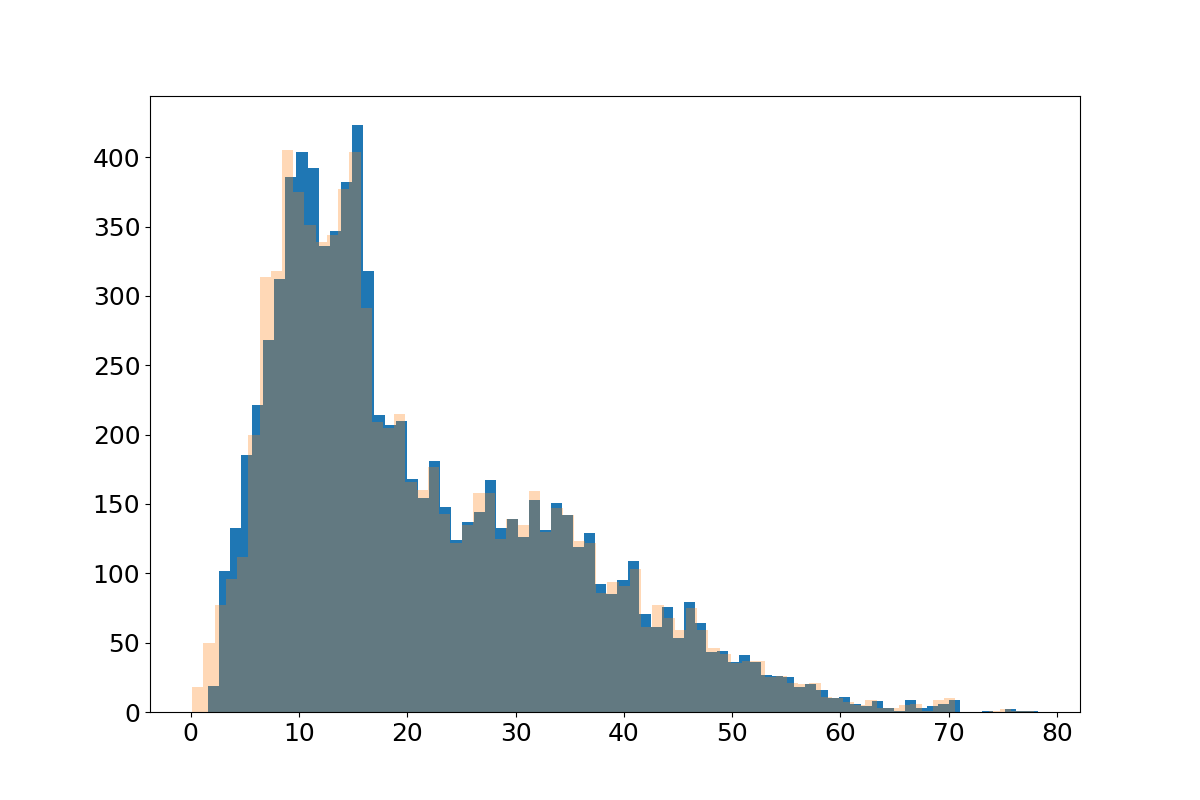

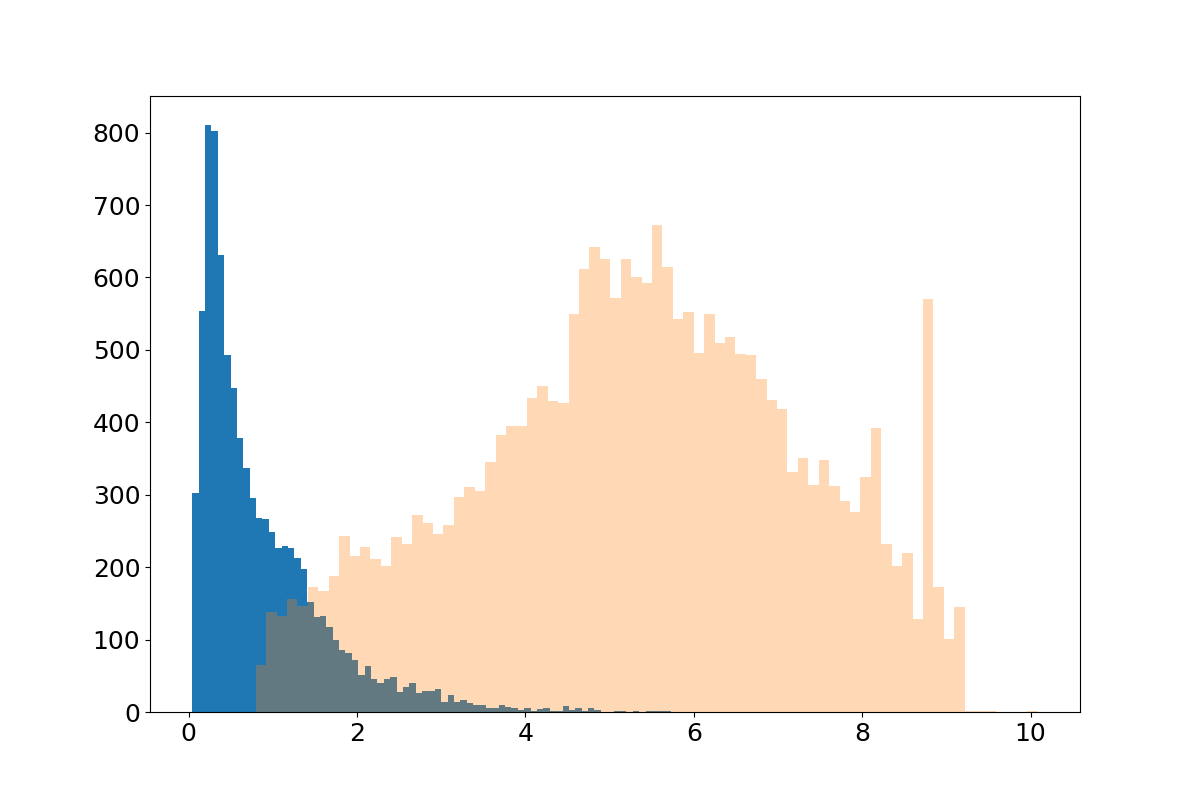

In [5]:
hdu1 = fits.open('../FITS_file/new_fits/new_S_map.fits')[1]
hdu2 = fits.open('../FITS_file/new_fits/S_map.fits')[1]


hdu3 = fits.open('../FITS_file/new_fits/new_sigma_S.fits')[1]
hdu4 = fits.open('../FITS_file/new_fits/sigma_S.fits')[1]

# fig = plt.figure(figsize=(13,10))
# plt.imshow(hdu.data,origin='lower')
# plt.show()
S_map_deb1 = hdu1
S_map_deb2 = hdu2
S_map_deb3 = hdu3
S_map_deb4 = hdu4


plt.figure(figsize=(12,8))
plt.hist(S_map_deb1.data.flatten(),75,alpha=1)
plt.hist(S_map_deb2.data.flatten(),75,alpha=0.3)
plt.show()

plt.figure(figsize=(12,8))
plt.hist(S_map_deb3.data.flatten(),75,alpha=1)
plt.hist(S_map_deb4.data.flatten(),75,alpha=0.3)
plt.show()

S_map_deb = hdu1
sigma_S_map = hdu3

(8501, 3)


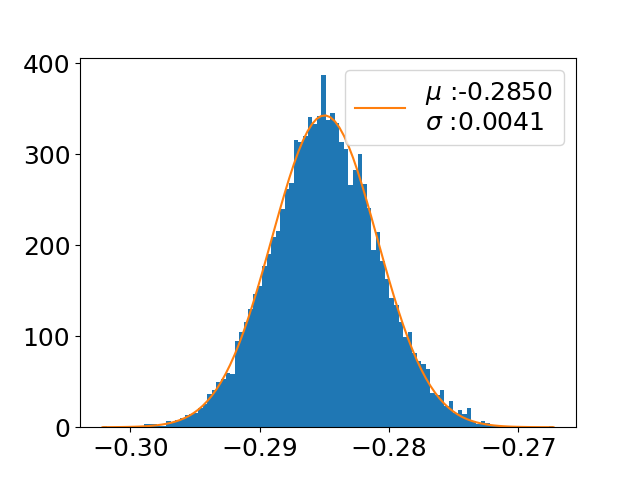

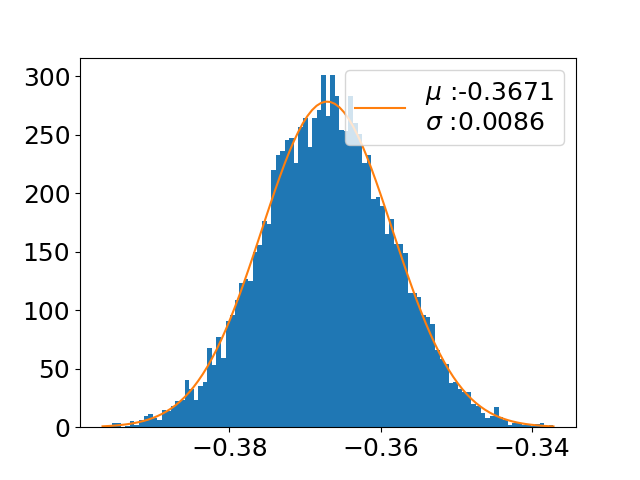

In [6]:
def gauss(x, *p):
    A, mu, sigma = p
    return A*np.exp(-(x-mu)**2/(2.*(sigma**2)))


def gauss_fit(array,delt):
    amax = np.nanmax(array)
    amin = np.nanmin(array)
    abin = np.linspace(amin,amax,delt)
    hist, bin_edges = np.histogram(array,abin)
    bin_centres = (bin_edges[:-1] + bin_edges[1:])/2
    p0 = [np.nanmax(array), np.nanmean(array), np.nanstd(array)]
    coeff, var_matrix = curve_fit(gauss, bin_centres, hist, p0=p0)
    hist_fit = gauss(abin, *coeff)
    plt.figure()
    plt.hist(array,abin)
    plt.plot(abin,hist_fit,label='$\mu$ :{mean:.4f}{linebreak}$\sigma$ :{std:.4f}'.format(linebreak='\n',mean =coeff[1],std=coeff[2]))
    plt.legend()



p_array = BlankedMapPol.data.flatten()
s_array = S_map_deb.data.flatten()
nh2_array = BlankedMapColumnDensity.data.flatten()
sigma_s_array = sigma_S_map.data.flatten()
p_error_array = BlankedMapPolError.data.flatten()
I_array = BlankedMapStokesI.data.flatten()
# syn_nh2_error = syn_error(nh2_array)


log_s = np.log10(s_array)
log_nh2 = np.log10(nh2_array)
log_p = np.log10(p_array)
log_I = np.log10(I_array)

df_log = pd.DataFrame({'logp': log_p,'logs':log_s,'logI':log_I})
df_log = df_log.dropna()

def DoubleParamFunc(X, a, b, c):
    x,y = X
    return a + b*x + c*y

def curve_fitting(x):
    param, param_cov = curve_fit(DoubleParamFunc,(x[:,2],x[:,1]),x[:,0])
    return param
    # return np.sqrt(np.diag(param_cov))


bootarr = np.array(df_log)
print(bootarr.shape)
bootresult = bootstrap(bootarr,10000,bootfunc=curve_fitting)

gauss_fit(bootresult[:,1],100)
plt.show()

gauss_fit(bootresult[:,2],100)
plt.show()


synthetic data for dispersion 


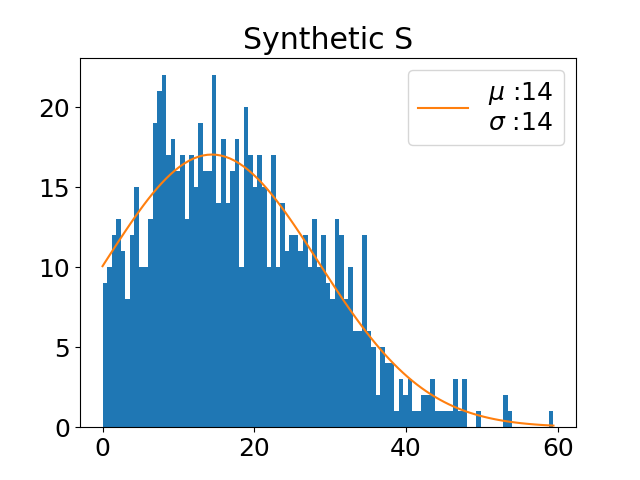

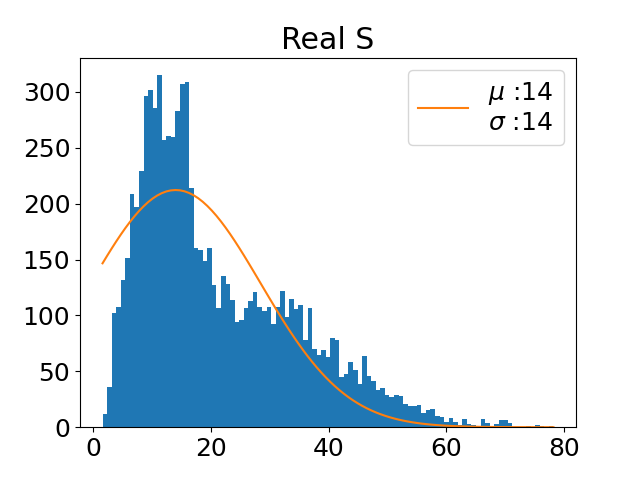

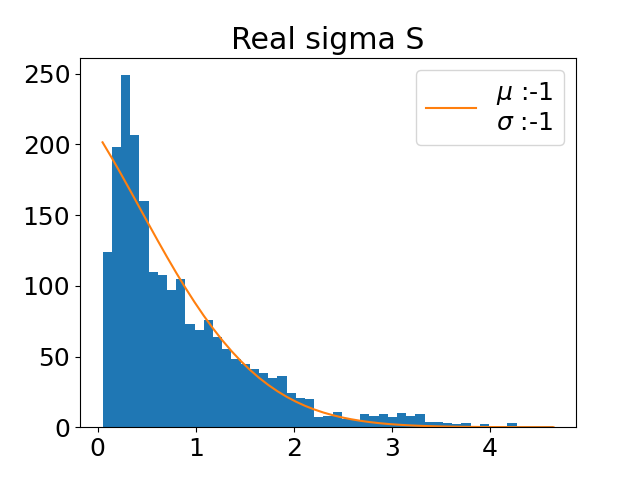

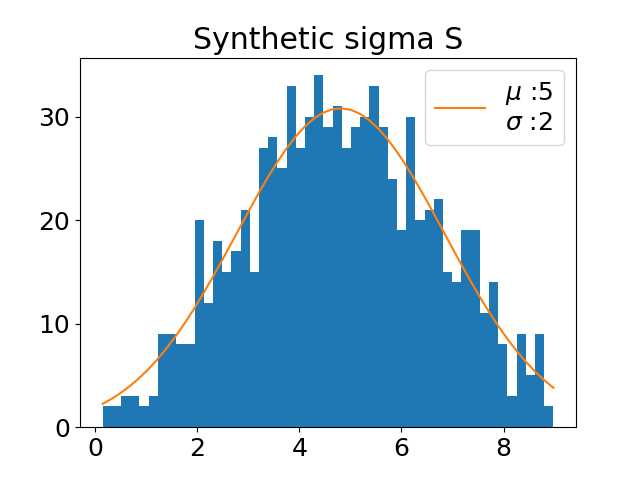

In [7]:
def gauss(x, *p):
    A, mu, sigma = p
    return A*np.exp(-(x-mu)**2/(2.*sigma**2))

def hist_plot(array,delt):
    amax = np.nanmax(array)
    amin = np.nanmin(array)
    abin = np.linspace(amin,amax,delt)
    plt.figure()
    plt.hist(array,abin,density=True)
    # return array,abin


def gauss_fit(array,delt):
    amax = np.nanmax(array)
    amin = np.nanmin(array)
    abin = np.linspace(amin,amax,delt)
    hist, bin_edges = np.histogram(array,abin)
    bin_centres = (bin_edges[:-1] + bin_edges[1:])/2
    p0 = [np.nanmax(array), np.nanmean(array), np.nanstd(array)]
    coeff, var_matrix = curve_fit(gauss, bin_centres, hist, p0=p0)
    hist_fit = gauss(abin, *coeff)
    plt.figure()
    plt.hist(array,abin)
    plt.plot(abin,hist_fit,label='$\mu$ :{mean:.0f}{linebreak}$\sigma$ :{std:.0f}'.format(linebreak='\n',mean =coeff[1],std=coeff[2]))
    plt.legend()


s_array = S_map_deb.data.flatten()
sigma_s_array = sigma_S_map.data.flatten()

s_array_ind = s_array.copy()
s_array_ind = s_array_ind[::4]
# s_array_ind = np.log(s_array_ind)

sigma_s_array_ind = sigma_s_array.copy()
sigma_s_array_ind = sigma_s_array_ind[::4]


# gauss_fit(s_array_ind,50)
# plt.plot()
# gauss_fit(sigma_s_array_ind,50)
# plt.plot()

syn_s_temp = np.random.normal(15,14,1000)
# syn_s_error= np.random.uniform(6,8,syn_s_temp.shape[0])
syn_s_error = np.random.normal(5,2,syn_s_temp.shape[0])

selector = (syn_s_temp < 0)
syn_s_temp[selector] = np.nan
syn_s_error[selector]= np.nan
selector = (syn_s_error < 0)
syn_s_temp[selector] = np.nan
syn_s_error[selector]= np.nan
selector = (syn_s_error > 9)
syn_s_temp[selector] = np.nan
syn_s_error[selector]= np.nan


df_s = pd.DataFrame({'syn_s': syn_s_temp,'syn_s_error':syn_s_error})
df_s = df_s.dropna()
gauss_fit(df_s['syn_s'],100)
plt.title('Synthetic S')
plt.show()

gauss_fit(s_array,100)
plt.title('Real S')
plt.show()

# plt.figure()
gauss_fit(sigma_s_array_ind,50)
plt.title('Real sigma S')
plt.show()

gauss_fit(syn_s_error,50)
plt.title('Synthetic sigma S')
plt.show()



Synthetic data for column density

1.0856708394627674
-11.672583183156506


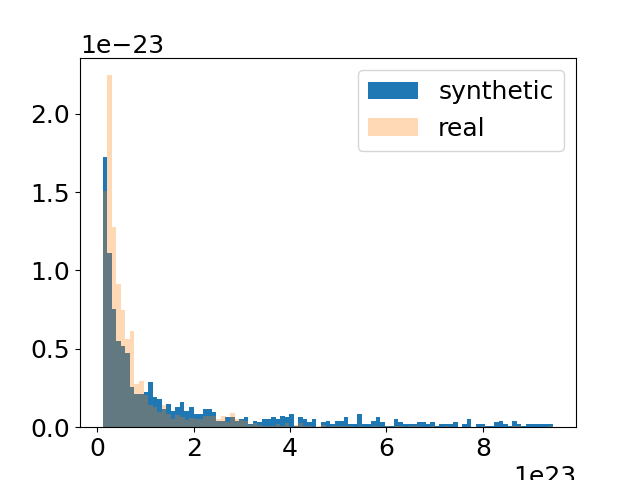

In [8]:
def rndm(a, b, g, size=1):
    """Power-law gen for pdf(x)\propto x^{g-1} for a<=x<=b"""
    r = np.random.random(size=size)
    ag, bg = a**g, b**g
    return (ag + (bg - ag)*r)**(1./g)

def powerlaw(x,*p):
    a,power = p
    return a*(x**(-1*power))

def syn_error(x):
    return np.random.normal(0,x*0.3,x.shape[0])


def bin_generator(array,delt):
    amax = np.nanmax(array)
    amin = np.nanmin(array)
    abin = np.linspace(amin,amax,delt)
    return array,abin

nh2_array = BlankedMapColumnDensity.data.flatten()
nh2_array_ind = nh2_array.copy()
nh2_array_ind = nh2_array_ind[::4]
array_min = np.nanmin(nh2_array_ind)
nh2_array_ind = nh2_array_ind

nh2_min = np.nanmin(nh2_array_ind)
nh2_max = np.nanmax(nh2_array_ind)
nh2_bins = np.linspace(nh2_min,nh2_max, 100)

hist, bin_edges = np.histogram(nh2_array_ind,nh2_bins)
temp_alpha = 1 + 1/(np.nanmean(np.log(nh2_array_ind/(np.nanmin(nh2_array_ind)))))
alpha = temp_alpha*0.65
print(alpha)
print(1./(-1*alpha+1))
syn_nh2_temp = rndm(nh2_min,nh2_max, g=(-1*alpha+1), size=syn_s_temp.shape[0])
syn_nh2_error = syn_error(syn_nh2_temp)

plt.figure()
syn,syn_bin = bin_generator(syn_nh2_temp,100)
nh2,nh2_bin = bin_generator(nh2_array_ind,100)
plt.hist(syn,syn_bin,density=True,label = 'synthetic')
plt.hist(nh2,nh2_bin,density=True,alpha=0.3,label = 'real')
plt.legend()
plt.show()

Synthetic data for Pfrac

[0.12174989 0.07836572]


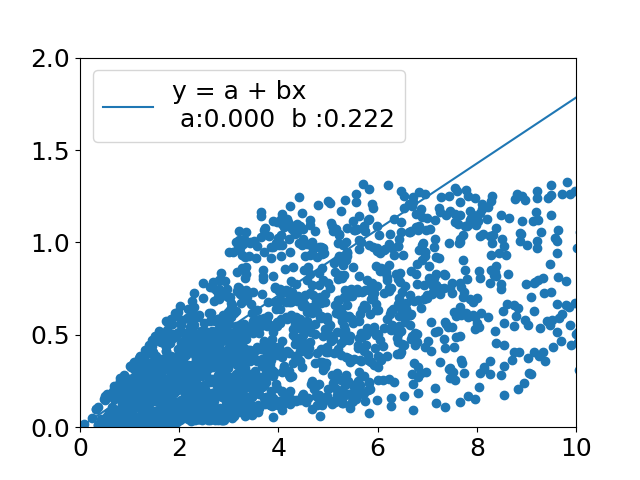

In [9]:
def lin_fit(x, a, b):
    return a + b*x

p_array = BlankedMapPol.data.flatten()
p_error_array = BlankedMapPolError.data.flatten()

p_array_ind = p_array.copy()
p_array_ind = p_array_ind[::4]
p_error_array_ind = p_error_array.copy()
p_error_array_ind = p_error_array_ind[::4]

p_min = np.nanmin(p_array_ind)
p_max = np.nanmax(p_array_ind)
p_bins = np.linspace(p_min, p_max, 150)

selector = ~np.isnan(p_array_ind)
p_array_fil = p_array_ind[selector]
p_error_array_fil = p_error_array_ind[selector]

# selector = p_array_fil < 10
# p_array_fil = p_array_fil[selector]
# p_error_array_fil = p_error_array_fil[selector]


param, param_cov = curve_fit(lin_fit, p_array_fil, p_error_array_fil)
FitFunc = lin_fit(p_bins,0,param[1]+0.1)
print(param)
plt.figure()
plt.scatter(p_array_fil, p_error_array_fil)
plt.plot(p_bins,FitFunc,label='y = a + bx{br} a:{a:.3f}{linebreak}b :{b:.3f}'.format(br='\n',linebreak='  ',a =0,b=param[0]+0.1))
plt.legend()
plt.xlim(0,10)
plt.ylim(0,2)
plt.show()

######## case with error in power and pfrac, S and NH2 Error order = 0.01
syn_s= syn_s_temp + syn_s_error
syn_nh2 = syn_nh2_temp + syn_nh2_error
syn_s_power = np.random.normal(-1,0.01,syn_s.shape[0])
syn_nh2_power = np.random.normal(-0.5,0.01,syn_s.shape[0])
syn_p_temp = 1e14*((syn_s)**(syn_s_power))*((syn_nh2)**(syn_nh2_power))
syn_p_error = syn_p_temp*(param[1]+0.1) + 0.093
syn_p = syn_p_temp+syn_p_error


######## case with error in pfrac, S and NH2 Error order = 0.0001-0.00001
# syn_s= syn_s_temp + syn_s_error
# syn_nh2 = syn_nh2_temp + syn_nh2_error
# syn_p_temp = 1e14*((syn_s)**(-1))*((syn_nh2)**(-0.5))
# syn_p_error = syn_p_temp*(param[1]+0.1) + 0.093
# syn_p = syn_p_temp+syn_p_error

######## case with error in power Error order = 0.01
# syn_s= syn_s_temp 
# syn_nh2 = syn_nh2_temp 
# syn_s_power = np.random.normal(-1,0.01,syn_s.shape[0])
# syn_nh2_power = np.random.normal(-0.5,0.01,syn_s.shape[0])
# syn_p_temp = 1e14*((syn_s)**(syn_s_power))*((syn_nh2)**(syn_nh2_power))
# syn_p = syn_p_temp

######## case with error in power and S and NH2 Error order = 0.01
# syn_s= syn_s_temp + syn_s_error
# syn_nh2 = syn_nh2_temp + syn_nh2_error
# syn_s_power = np.random.normal(-1,0.01,syn_s.shape[0])
# syn_nh2_power = np.random.normal(-0.5,0.01,syn_s.shape[0])
# syn_p_temp = 1e14*((syn_s)**(syn_s_power))*((syn_nh2)**(syn_nh2_power))
# syn_p = syn_p_temp


# log_s = np.log10(syn_s)
# log_nh2 = np.log10(syn_nh2)
# log_p = np.log10(syn_p)

# plt.figure()
# plt.scatter(log_nh2,log_p)
# plt.show()


Doing bootstrap for the synthetic data

In [10]:
log_s = np.log10(syn_s)
log_nh2 = np.log10(syn_nh2)
log_p = np.log10(syn_p)

df_log = pd.DataFrame({'logp': log_p,'logs':log_s,'lognh2':log_nh2})
df_log = df_log.dropna()

def DoubleParamFunc(X, a, b, c):
    x,y = X
    return a + b*x + c*y

def curve_fitting(x):
    param, param_cov = curve_fit(DoubleParamFunc,(x[:,2],x[:,1]),x[:,0])
    # return param
    return np.sqrt(np.diag(param_cov))


bootarr = np.array(df_log)
bootresult = bootstrap(bootarr,10,bootfunc=curve_fitting)
print(bootresult)

# hist_plot(bootresult[:,1],50)
# plt.show()

[[0.32393438 0.0139475  0.03237644]
 [0.32333125 0.01407308 0.03304155]
 [0.32898253 0.01415499 0.03294528]
 [0.32205218 0.01391368 0.03273269]
 [0.32079476 0.01396072 0.03200869]
 [0.3182768  0.01385213 0.03196257]
 [0.3089458  0.01339895 0.03119183]
 [0.31776359 0.0137185  0.03281991]
 [0.32659772 0.01414216 0.03343513]
 [0.31736659 0.01368589 0.03244779]]


In [11]:
def DoubleParamFunc(X, a, b, c):
    x,y = X
    return a + b*x + c*y

df = pd.DataFrame({'syn_s': np.log10(syn_s),'syn_nh2':np.log10(syn_nh2),'syn_p':np.log10(syn_p)})
df = df.dropna()


p0 = -0.2278, -0.8567, 2.
PSI_param_lower, PSI_param_cov_lower = curve_fit(DoubleParamFunc,(df['syn_s'],df['syn_nh2']),df['syn_p'],p0)
print('C :',PSI_param_lower[0])
print('s index :',PSI_param_lower[1])
print('nh2 index :',PSI_param_lower[2])

C : 13.942019872657891
s index : -0.9797490968457876
nh2 index : -0.4959260078571682


working with real data

In [12]:
def syn_error(x):
    return np.random.normal(0,x*0.3,x.shape[0])


p_array = BlankedMapPol.data.flatten()
s_array = S_map_deb.data.flatten()
nh2_array = BlankedMapColumnDensity.data.flatten()
sigma_s_array = sigma_S_map.data.flatten()
p_error_array = BlankedMapPolError.data.flatten()
I_array = BlankedMapStokesI.data.flatten()
syn_nh2_error = syn_error(nh2_array)


log_s = np.log10(s_array)
log_nh2 = np.log10(nh2_array)
log_p = np.log10(p_array)
log_I = np.log10(I_array)

df_log = pd.DataFrame({'logp': log_p,'logs':log_s,'lognh2':log_nh2})
df_log = df_log.dropna()

def DoubleParamFunc(X, a, b, c):
    x,y = X
    return a + b*x + c*y

def curve_fitting(x):
    param, param_cov = curve_fit(DoubleParamFunc,(x[:,2],x[:,1]),x[:,0])
    # return param
    return np.sqrt(np.diag(param_cov))


bootarr = np.array(df_log)
print(bootarr.shape)
bootresult = bootstrap(bootarr,10,bootfunc=curve_fitting)
print(bootresult)

(8501, 3)
[[0.1483078  0.00662928 0.00887218]
 [0.1467651  0.00655717 0.00871382]
 [0.14761698 0.00660263 0.00870985]
 [0.14815025 0.00661578 0.00884324]
 [0.14915392 0.00666665 0.00877125]
 [0.14728387 0.00658107 0.00879965]
 [0.1488029  0.0066568  0.00882985]
 [0.14891384 0.00666193 0.00880302]
 [0.14979183 0.0066908  0.00867087]
 [0.14595857 0.00652115 0.00864309]]


In [13]:

def lin_fit(x, a, b):
    return a + b*x


def single_curve_fitting(x):
    param, param_cov = curve_fit(lin_fit,x[:,0],x[:,1])
    # return param
    return np.sqrt(np.diag(param_cov))



df_log = pd.DataFrame({'logs':log_s,'logp': log_p})
df_log = df_log.dropna()
bootarr = np.array(df_log)

# plt.figure(figsize=(12,8))
# plt.scatter(bootarr[:,0],bootarr[:,1])
# plt.show()

bootresult = bootstrap(bootarr,bootnum = 10,bootfunc=single_curve_fitting)
print(bootresult)


# x = np.array([df_log['logs'],df_log['logp']])
# print(x)

# print(curve_fit(lin_fit,(x[0,:]),x[1,:]))

# print('error in alpha_s',np.nanstd(bootresult[:,1]))

[[0.01369676 0.01072312]
 [0.01368422 0.01073355]
 [0.01359794 0.01062716]
 [0.01371417 0.01076279]
 [0.01349143 0.01056479]
 [0.01318408 0.01036687]
 [0.01338757 0.01050144]
 [0.01366787 0.01069814]
 [0.0134257  0.01050143]
 [0.01344141 0.01051077]]


In [14]:
# s_array = S_map_deb.data.flatten()
# p_array = BlankedMapPol.data.flatten()
# I_array = BlankedMapStokesI.data.flatten()
# nh2_array = BlankedMapColumnDensity.data.flatten()

# ############# making the data independent
# s_array_ind = s_array.copy()
# s_array_ind = s_array_ind[::4]
# p_array_ind = p_array.copy()
# p_array_ind = p_array_ind[::4]
# I_array_ind = I_array.copy()
# I_array_ind = I_array_ind[::4]
# nh2_array_ind = nh2_array.copy()
# nh2_array_ind = nh2_array_ind[::4]


In [15]:
def lin_fit(x, a, b):
    return a + b*x

def DoubleParamFunc(X, a, b, c):
    x,y = X
    return a + b*x + c*y

def curve_fitting(x):
    param, param_cov = curve_fit(DoubleParamFunc,(x[:,1],x[:,2]),x[:,0])
    return param


def remove_nan(array1,array2):
    selector = ~np.isnan(array1)
    array1_fil = array1[selector]
    array2_fil = array2[selector]

    selector = ~np.isnan(array2_fil)
    array1_fil = array1_fil[selector]
    array2_fil = array2_fil[selector]
    return array1_fil,array2_fil

def binning_equal_width_bootstrap(x,Nbins = 11):
    array1 = x[0,:]
    array2 = x[1,:]

    filtered1,filtered2 = remove_nan(array1,array2)
    log_filtered1 = np.log10(filtered1)
    log_filtered2 = np.log10(filtered2)

    # print('filtered1')
    # print(filtered1)
    # print('filtered2')
    # print(filtered2)
    
    bins = np.linspace(np.nanmin(log_filtered1),np.nanmax(log_filtered1),Nbins)
    # bin_centres = (bins[:-1] + bins[1:])/2

    bin_centres = []
    binned_data = []
    error_bar = []

    for i in range(0,(bins.shape[0]-1)):
        temp_array1 = filtered1.copy()
        temp_array2 = filtered2.copy()

        Selector = log_filtered1 < bins[i]
        temp_array1[Selector] = np.nan
        temp_array2[Selector] = np.nan
        Selector =  log_filtered1 > bins[i+1]
        temp_array1[Selector] = np.nan
        temp_array2[Selector] = np.nan

        bin_centres.append(np.nanmean(temp_array1))
        binned_data.append(np.nanmean(temp_array2))
        error_bar.append(np.nanstd(temp_array2))




    # print('bin centres')
    # print(bin_centres)
    # print('bin data')
    # print(binned_data)

    bin_centres = np.log10(np.array(bin_centres))
    binned_data = np.log10(np.array(binned_data))

    bin_centres,binned_data = remove_nan(bin_centres,binned_data)
    param, param_cov = curve_fit(lin_fit, bin_centres,binned_data)

    return np.sqrt(np.diag(param_cov))
    # return param

# plt.figure()
# plt.scatter(fil1,fil2)
# plt.xscale('log')
# plt.yscale('log')
# plt.show()
# print(binning_equal_width_bootstrap(np.array([I_array_ind,p_array_ind])))


print('\n','Single parameter','\n','p vs IS')
bootresult = bootstrap(np.array([I_array,p_array]),bootnum = 5,bootfunc=binning_equal_width_bootstrap)
print('\n','bootresult')
print(bootresult)









 Single parameter 
 p vs IS

 bootresult
[[       inf        inf]
 [0.02553643 0.02511356]
 [0.10142723 0.13868714]
 [0.02553643 0.02511356]
 [0.10142723 0.13868714]]


c:\Users\DELL\anaconda3\envs\polarimetry\lib\site-packages\scipy\optimize\_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


Playing with scipy

In [16]:
def gauss(x, *p):
    A, mu, sigma = p
    return A*np.exp(-(x-mu)**2/(2.*sigma**2))

def hist_plot(array,delt):
    amax = np.nanmax(array)
    amin = np.nanmin(array)
    abin = np.linspace(amin,amax,delt)
    plt.figure()
    plt.hist(array,abin,density=True)
    # return array,abin


def gauss_fit(array,delt):
    amax = np.nanmax(array)
    amin = np.nanmin(array)
    abin = np.linspace(amin,amax,delt)
    hist, bin_edges = np.histogram(array,abin)
    bin_centres = (bin_edges[:-1] + bin_edges[1:])/2
    p0 = [np.nanmax(array), np.nanmean(array), np.nanstd(array)]
    coeff, var_matrix = curve_fit(gauss, bin_centres, hist, p0=p0)
    hist_fit = gauss(abin, *coeff)
    plt.figure()
    plt.hist(array,abin)
    plt.plot(abin,hist_fit,label='$\mu$ :{mean:.0f}{linebreak}$\sigma$ :{std:.0f}'.format(linebreak='\n',mean =coeff[1],std=coeff[2]))
    plt.legend()





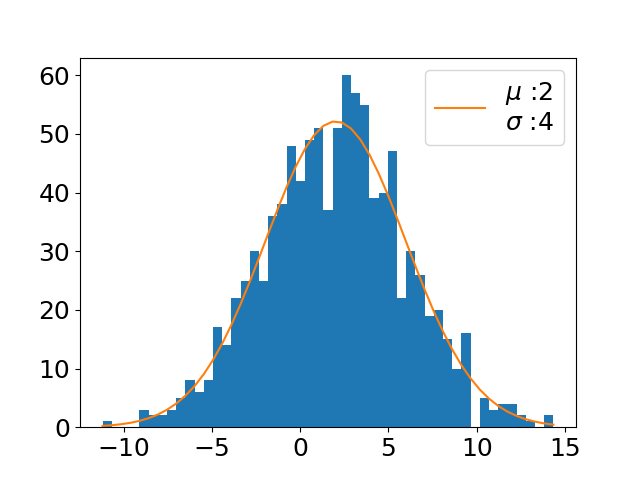

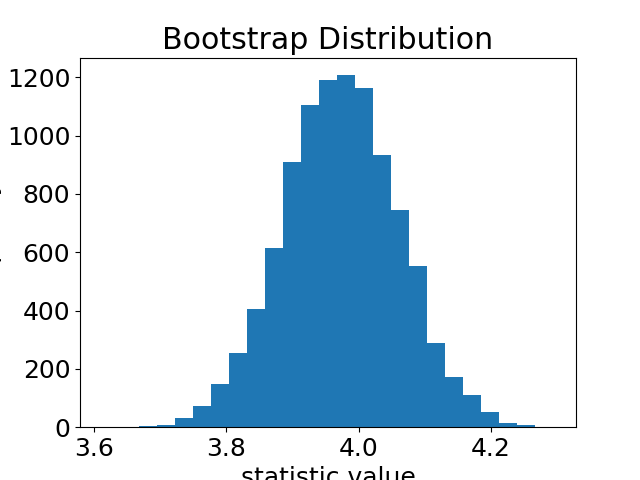

In [19]:
from scipy.stats import bootstrap as bt

import numpy as np
rng = np.random.default_rng()
from scipy.stats import norm
dist = norm(loc=2, scale=4)  # our "unknown" distribution
data = dist.rvs(size=1000, random_state=rng)
gauss_fit(data,50)
plt.show()

def test(x):
    return 2*np.mean(x)

data = (data,)  # samples must be in a sequence
res = bt(data, np.std, confidence_level=0.9,random_state=rng)
fig, ax = plt.subplots()
ax.hist(res.bootstrap_distribution, bins=25)
ax.set_title('Bootstrap Distribution')
ax.set_xlabel('statistic value')
ax.set_ylabel('frequency')
plt.show()

In [18]:
res

BootstrapResult(confidence_interval=ConfidenceInterval(low=1765.446101269795, high=2170.8489503435776), bootstrap_distribution=array([2090.12189423, 2062.2895725 , 2202.72890529, ..., 1893.53933306,
       2082.98439536, 1916.5609111 ]), standard_error=123.98322426481157)